<a href="https://colab.research.google.com/github/vanderbilt-ml/50-shah-mlproj-traffic-accidents/blob/main/TrafficAccidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

#Traffic Accidents

## Background

This is dataset of traffic accidents reported from 2019 to present. The data has been retrieved using manual export and is subject to change during an investigation as more information becomes available.

## Project Description

Each record is a reported traffic accident. Check the metadata field descriptions for more detailed information.

### **Data Dictionary**

Feature	|	Description	|	Type
-------------	|	-------------	|	-------------
AccidentNumber	|	MNPD incident number for the crash	|	Plain Text
AccidentDate	|	Date of the accident	|	Date & Time
Injury	|	Injury reported	|	CheckBox
Fatality	|	Fatality reported	|	CheckBox
PropertyDamage	|	Indicates if there was property damage as a result of the accident	|	Checkbox
HitAndRun	|	Indicates if the accident was a hit and run	|	Checkbox
CollisionType	|	Full text description of the collision type	|	Plain Text
Weather	|	Full text description of the weather conditions	|	Plain Text
Illumination	|	Full text description of the lighting conditions	|	Plain Text
Precinct	|	Assigned precinct in which the accident occurred	|	Plain Text

In [280]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context, tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

## Load Data

Load the traffic accidents data provided using pandas and read it as a dataframe. Please note that the The repository is private so I have to use token to access .csv file.

In [324]:
penguins = pd.read_csv('https://raw.githubusercontent.com/vanderbilt-ml/50-shah-mlproj-traffic-accidents/main/Traffic_Accidents.csv')
display(penguins.head())
penguins.info()

,AccidentNumber,AccidentDate,Injury,Fatality,PropertyDamage,HitAndRun,CollisionType,Weather,Illumination,Precinct
0,20200046129,1/31/2022,False,False,False,False,SIDESWIPE - SAME DIRECTION,CLEAR,DAYLIGHT,WEST
1,20200099766,3/4/2022,False,False,False,False,ANGLE,CLEAR,DAYLIGHT,CENTRA
2,20200181991,4/15/2022,True,False,False,False,ANGLE,CLOUDY,DAYLIGHT,HERMIT
3,20210016364,1/12/2022,False,False,True,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,CENTRA
4,20220000022,1/1/2022,False,False,False,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - NOT LIGHTED,WEST


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7762 entries, 0 to 7761
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AccidentNumber  7762 non-null   int64 
 1   AccidentDate    7762 non-null   object
 2   Injury          7762 non-null   bool  
 3   Fatality        7762 non-null   bool  
 4   PropertyDamage  7762 non-null   bool  
 5   HitAndRun       7762 non-null   bool  
 6   CollisionType   7762 non-null   object
 7   Weather         7762 non-null   object
 8   Illumination    7762 non-null   object
 9   Precinct        7762 non-null   object
dtypes: bool(4), int64(1), object(5)
memory usage: 394.3+ KB


### Data Cleaning
Detect and Remove Missing values

After exploring and observing the data, there are a few columns with the coded value for which the description is already available. I am removing data values out of the dataframe.

The columns are specified below:

**Date and Time**, **Reporting Officer**, **Collision Type Code**, **Weather Code**, **Illumination Code**, **Harmful Code**, **RPA**

In [282]:
penguins.isnull().sum()

AccidentNumber    0
AccidentDate      0
Injury            0
Fatality          0
PropertyDamage    0
HitAndRun         0
CollisionType     0
Weather           0
Illumination      0
Precinct          0
dtype: int64

## Feature Engineering

There are many feature engineering techniques including e.g. Imputation, Handling Outliers, Binning, Log Transform, One-Hot Encoding, Grouping Operations, Feature Split, Scaling etc. 

We will be applying lesson learned from various assignments lets create some statistics on the  data attached here. Also create the test and train set, pipeline and check/learn the outcome of the data.

In [283]:
penguins.shape
penguins.head()

,AccidentNumber,AccidentDate,Injury,Fatality,PropertyDamage,HitAndRun,CollisionType,Weather,Illumination,Precinct
0,20200046129,1/31/2022,False,False,False,False,SIDESWIPE - SAME DIRECTION,CLEAR,DAYLIGHT,WEST
1,20200099766,3/4/2022,False,False,False,False,ANGLE,CLEAR,DAYLIGHT,CENTRA
2,20200181991,4/15/2022,True,False,False,False,ANGLE,CLOUDY,DAYLIGHT,HERMIT
3,20210016364,1/12/2022,False,False,True,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,CENTRA
4,20220000022,1/1/2022,False,False,False,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - NOT LIGHTED,WEST


**Total Number of accidents based on Collission Type**

In [284]:
penguins["CollisionType"].unique()

array(['SIDESWIPE - SAME DIRECTION', 'ANGLE',
       'NOT COLLISION W/MOTOR VEHICLE-TRANSPORT', 'Front to Rear',
       'HEAD-ON', 'OTHER', 'Rear to Side',
       'SIDESWIPE - OPPOSITE DIRECTION', 'REAR-TO-REAR'], dtype=object)

In [285]:
collision_types = penguins["CollisionType"].unique()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


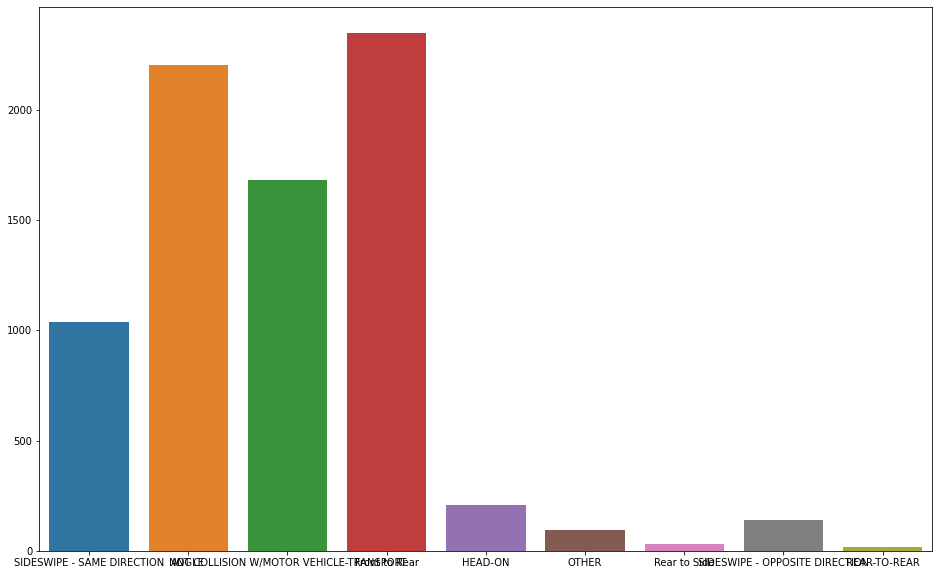

In [286]:
counts_by_collision_type=[]
for i in penguins["CollisionType"].unique(): counts_by_collision_type.append(penguins[penguins['CollisionType']==i].count()['AccidentNumber'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(collision_types, counts_by_collision_type)

**Total Number of accidents based on Weather Condition**

In [287]:
penguins["Weather"].unique()

array(['CLEAR', 'CLOUDY', 'RAIN', 'SNOW', 'SLEET, HAIL', 'BLOWING SNOW',
       'FOG', 'OTHER (NARRATIVE)'], dtype=object)

In [273]:
weather_conditions = penguins["Weather"].unique()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


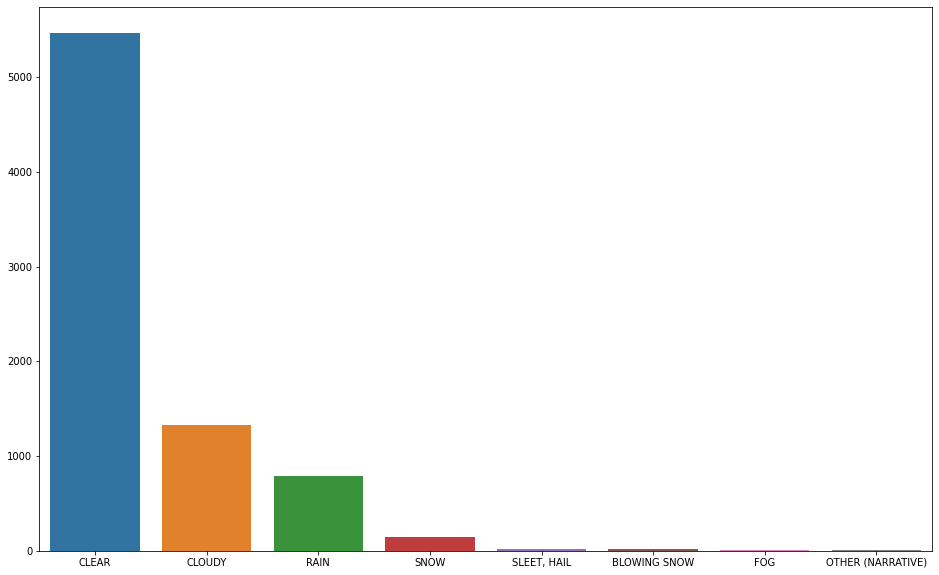

In [288]:
counts_by_weather_condition=[]
for i in penguins["Weather"].unique(): counts_by_weather_condition.append(penguins[penguins['Weather']==i].count()['AccidentNumber'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(weather_conditions, counts_by_weather_condition)

**Total Number of accidents by Day Of Week**

In [289]:
accident_DOW = pd.to_datetime(penguins["AccidentDate"]).dt.day_name().unique()

In [276]:
print(accident_DOW)

['Monday' 'Friday' 'Wednesday' 'Saturday' 'Sunday' 'Tuesday' 'Thursday']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


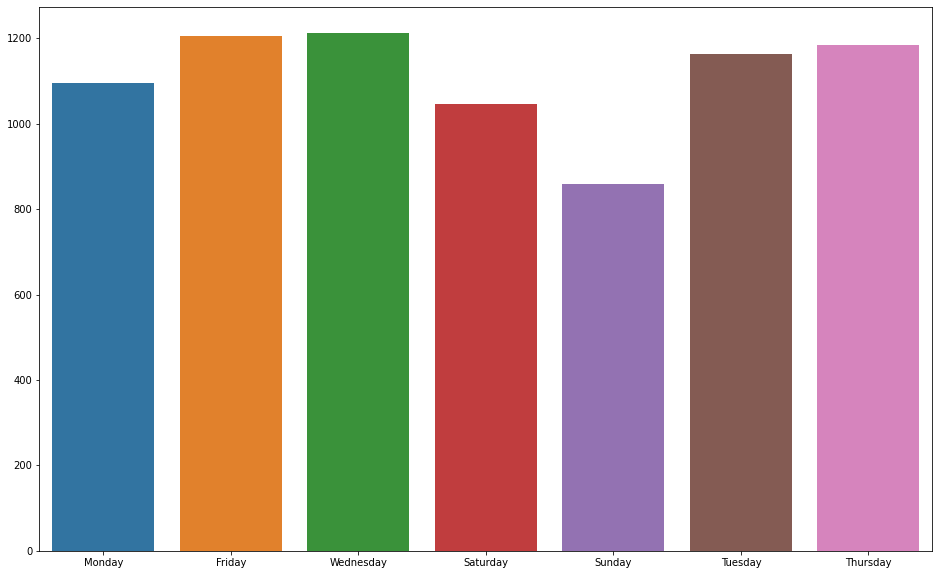

In [290]:
counts_by_DOW=[]
for i in pd.to_datetime(penguins["AccidentDate"]).dt.day_name().unique(): counts_by_DOW.append(penguins[pd.to_datetime(penguins["AccidentDate"]).dt.day_name()==i].count()['AccidentNumber'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(accident_DOW, counts_by_DOW)

In [291]:
penguins = penguins.drop(columns=['AccidentDate'])
penguins.shape
print(penguins.columns)

Index(['AccidentNumber', 'Injury', 'Fatality', 'PropertyDamage', 'HitAndRun',
       'CollisionType', 'Weather', 'Illumination', 'Precinct'],
      dtype='object')


**Build Test and Train Set**

In [292]:
class_column = 'HitAndRun'
random_seed = 2435

X_train, X_test, Y_train, Y_test = train_test_split(penguins.drop(columns=class_column), penguins[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=penguins[class_column])

In [293]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (5821, 8)


,AccidentNumber,Injury,Fatality,PropertyDamage,CollisionType,Weather,Illumination,Precinct
1302,20220044216,False,False,False,ANGLE,CLEAR,DARK - LIGHTED,MIDTOW
1531,20220051237,False,False,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,RAIN,DAYLIGHT,HERMIT
3423,20220115406,False,False,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,WEST
6096,20220221510,False,False,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - LIGHTED,NORTH
2208,20220073712,False,False,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLOUDY,DAWN,EAST



On X test: 
X test dimensions:  (1941, 8)


,AccidentNumber,Injury,Fatality,PropertyDamage,CollisionType,Weather,Illumination,Precinct
7275,20220266122,False,False,True,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,CENTRA
4519,20220162176,True,False,False,Front to Rear,CLEAR,DARK - LIGHTED,SOUTH
7483,20220274557,False,False,False,Front to Rear,CLEAR,DAYLIGHT,HERMIT
6452,20220235366,False,False,False,Front to Rear,CLEAR,DAYLIGHT,CENTRA
2261,20220075449,True,False,True,Front to Rear,CLOUDY,DARK - LIGHTED,SOUTH


In [294]:
# Y Train
print('On y train: ')
print('y train dimensions: ', Y_train.shape)
display(Y_train.head())

# Y test
print('\nOn y test: ')
print('y test dimensions: ', Y_test.shape)
display(Y_test.head())

On y train: 
y train dimensions:  (5821,)


1302    False
1531    False
3423    False
6096    False
2208    False
Name: HitAndRun, dtype: bool


On y test: 
y test dimensions:  (1941,)


7275    False
4519    False
7483    False
6452    False
2261    False
Name: HitAndRun, dtype: bool

### Training pipeline

Establish the training pipeline for model and repeat several times as needed The pipeline can also change depending on the data types of the columns in the dataset.

In [295]:
#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])

In [296]:
#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

### Logistic Regression

In [297]:
#generate the whole modeling pipeline with preprocessing
pipe_lg = Pipeline(steps=[('preproc', preproc), ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

#visualization for steps
with config_context(display='diagram'): display(pipe_lg)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007cd0>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

### Random Forest Classifier

In [298]:
pipe_rf = Pipeline([('preproc', preproc), ('rf', RandomForestClassifier())])

# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'): display(pipe_rf)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007cd0>)])),
                ('rf', RandomForestClassifier())])

### Gradient Boosting Classifier

In [299]:
pipe_gb = Pipeline(steps=[('preproc', preproc), ('gbc', GradientBoostingClassifier())])


# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'): display(pipe_gb)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007cd0>)])),
                ('gbc', GradientBoostingClassifier())])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

### Logistic Regression

In [300]:
tuning_grid_lg = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }
grid_search_lg = GridSearchCV(pipe_lg, param_grid = tuning_grid_lg, cv = 5, return_train_score=True)

In [301]:
tuning_grid_lg

{'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06]),
 'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])}

In [302]:
grid_search_lg.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                                        ('num_pipe',
                                                    

In [303]:
print(grid_search_lg.best_score_)
grid_search_lg.best_params_

0.8137768240343346


{'mdl__C': 316.22776601683796, 'mdl__l1_ratio': 0.5}

In [304]:
pd.DataFrame(grid_search_lg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,param_mdl__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.048264,0.005567,0.010091,0.000460,0.1,0.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}",0.818026,0.810997,0.812715,...,0.812746,0.002776,11,0.810782,0.813184,0.812540,0.811252,0.813614,0.812274,0.001092
1,0.063997,0.005955,0.010261,0.000262,0.1,0.25,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}",0.817167,0.810997,0.811856,...,0.812231,0.002527,12,0.810352,0.812970,0.812540,0.811037,0.812755,0.811931,0.001041
2,0.059580,0.005430,0.010966,0.001312,0.1,0.5,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}",0.817167,0.810137,0.811856,...,0.812059,0.002633,13,0.810782,0.812755,0.812111,0.811037,0.811681,0.811673,0.000716
3,0.059230,0.004956,0.010496,0.001100,0.1,0.75,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}",0.817167,0.810137,0.811856,...,0.812059,0.002633,13,0.809708,0.812540,0.811896,0.811037,0.811252,0.811287,0.000949
4,0.056247,0.005177,0.009787,0.000050,0.1,1.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}",0.814592,0.810137,0.811856,...,0.811716,0.001537,15,0.810137,0.811896,0.811896,0.811037,0.811037,0.811201,0.000656
5,0.049483,0.003577,0.010815,0.001026,316.227766,0.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.818026,0.811856,0.811856,...,0.813605,0.002300,3,0.812500,0.813829,0.812970,0.812326,0.813829,0.813091,0.000638
6,0.085676,0.004321,0.010708,0.000158,316.227766,0.25,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.818026,0.811856,0.811856,...,0.813605,0.002300,3,0.812285,0.814043,0.813184,0.812540,0.813829,0.813176,0.000689
7,0.081145,0.006363,0.010299,0.000306,316.227766,0.5,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.818884,0.811856,0.811856,...,0.813777,0.002632,1,0.812500,0.813614,0.812755,0.812326,0.813829,0.813005,0.000605
8,0.080572,0.005649,0.009997,0.000192,316.227766,0.75,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.817167,0.811856,0.811856,...,0.813433,0.001973,8,0.812500,0.813829,0.813399,0.812326,0.813829,0.813176,0.000645
9,0.081450,0.007090,0.009945,0.000145,316.227766,1.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.817167,0.811856,0.811856,...,0.813433,0.001973,8,0.812500,0.814258,0.812755,0.812326,0.814043,0.813176,0.000810


### Random Forest Classifier

In [305]:
tuning_grid_rf = param_grid = {'rf__n_estimators': [10, 50],
                                        'rf__max_features': ['auto', 'sqrt', 'log2'],
                                        'rf__max_depth' : [4,5,6],
                                        'rf__criterion' :['gini', 'entropy']
                                       }
grid_search_rf = GridSearchCV(pipe_rf, param_grid = tuning_grid_rf, cv = 5, return_train_score=True)

In [306]:
grid_search_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                                        ('num_pipe',
                                                    

In [307]:
pipe_rf.fit(X_train, Y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

In [308]:
grid_search_rf.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 5,
 'rf__max_features': 'log2',
 'rf__n_estimators': 10}

In [309]:
print(grid_search_rf.best_score_)

0.8112008318216007


### Gradient Boosting Classifier

In [310]:
tuning_grid_gb = param_grid = {'gbc__learning_rate': [1, 0.5, 0.25],
                                       'gbc__n_estimators': [64, 128, 256],
                                       'gbc__max_depth': [2, 4],
                                       'gbc__min_samples_split': [2, 4]
                                      }
grid_search_gb = GridSearchCV(pipe_gb, param_grid = tuning_grid_gb, cv = 5, return_train_score=True)

In [311]:
grid_search_gb.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                                        ('num_pipe',
                                                    

In [312]:
pipe_gb.fit(X_train, Y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779007c10>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

In [313]:
grid_search_gb.best_params_

{'gbc__learning_rate': 0.25,
 'gbc__max_depth': 2,
 'gbc__min_samples_split': 2,
 'gbc__n_estimators': 64}

In [314]:
print(grid_search_gb.best_score_)

0.8120594958925121


## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

### Logistic Regression

In [315]:
grid_search_lg.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7798bc150>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

### Random Forest Classifier

In [316]:
grid_search_rf.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7795c0f10>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

### Gradient Boosting Classifier

In [317]:
grid_search_gb.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779011290>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

### Logistic Regression

In [319]:
grid_search_lg.classes_

array([False,  True])

In [320]:
vip_lg = grid_search_lg.best_estimator_['mdl'].coef_[0]
vip_lg

array([-5.35658901e-01, -3.80686681e-01, -8.36798196e-02, -9.91266427e-01,
        1.20763863e-01,  1.41389813e-01,  1.83924571e-01,  3.19796221e-01,
       -1.37877114e-02, -2.71298069e-02, -2.57925263e-02, -4.17583830e-01,
       -2.54135309e-04, -4.15692503e-02, -4.17455586e-01, -6.77514202e-02,
       -2.41257569e-01,  3.67970048e-02, -2.29152214e-01, -1.47706095e-01,
       -7.96758510e-01, -1.64241486e-01,  1.27895463e-01, -6.58174260e-02,
       -6.05537558e-01,  2.14174611e-02, -2.06854192e-01,  2.00426818e-01,
       -3.29152118e-01, -9.35416322e-02,  1.19709498e-01, -1.31100611e-02,
       -3.32317948e-01,  1.78858218e-01, -9.49057384e-01,  0.00000000e+00,
        3.74724041e-01])

In [321]:
#get names in correct preproc order
cat_names = grid_search_lg.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
cat_names

array(['x0_ANGLE', 'x0_Front to Rear', 'x0_HEAD-ON',
       'x0_NOT COLLISION W/MOTOR VEHICLE-TRANSPORT', 'x0_OTHER',
       'x0_REAR-TO-REAR', 'x0_Rear to Side',
       'x0_SIDESWIPE - OPPOSITE DIRECTION',
       'x0_SIDESWIPE - SAME DIRECTION', 'x1_BLOWING SNOW', 'x1_CLEAR',
       'x1_CLOUDY', 'x1_FOG', 'x1_OTHER (NARRATIVE)', 'x1_RAIN',
       'x1_SLEET, HAIL', 'x1_SNOW', 'x2_DARK - LIGHTED',
       'x2_DARK - NOT LIGHTED', 'x2_DAWN', 'x2_DAYLIGHT', 'x2_DUSK',
       'x2_Dark-Unknown Lighting', 'x2_OTHER', 'x3_CENTRA', 'x3_EAST',
       'x3_HERMIT', 'x3_MADISO', 'x3_MIDTOW', 'x3_NORTH', 'x3_SOUTH',
       'x3_Unknown', 'x3_WEST'], dtype=object)

In [322]:
num_names = grid_search_lg.best_estimator_.named_steps['preproc'].transformers_[1][2]
num_names

['AccidentNumber']

In [323]:
#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_lg})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize=(10, 10)) 
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

ValueError: ignored

### Random Forest Classifier

In [ ]:
grid_search_rf.classes_

In [ ]:
vip_rf = grid_search_rf.best_estimator_['rf']
vip_rf

In [ ]:
cat_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[1][2]
vip_rf = grid_search_rf.best_estimator_.steps[1]
vip_rf = vip_rf[1].estimators_

plt.figure(figsize=(18, 12)) 
tree.plot_tree(vip_rf[0], feature_names=np.hstack([cat_names, num_names]), fontsize=8, filled=True)
plt.show()

### Gradient Boosting Classifier

In [ ]:
grid_search_gb.classes_

In [ ]:
vip_gb = grid_search_gb.best_estimator_['gbc']
vip_gb

## Performance metrics on test data

Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

### Logistic Regression

In [ ]:
print(classification_report(Y_test, grid_search_lg.best_estimator_.predict(X_test)))

In [ ]:
cm_lg = confusion_matrix(Y_test, grid_search_lg.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg,
                               display_labels=grid_search_lg.classes_)
disp.plot()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test.reset_index(drop=True), grid_search_lg.best_estimator_.predict(X_test)))
mape = mean_absolute_percentage_error(Y_test.reset_index(drop=True),grid_search_lg.best_estimator_.predict(X_test))
r2 = r2_score(Y_test.reset_index(drop=True), grid_search_lg.best_estimator_.predict(X_test))

print('lg R2 is: {0}'.format(r2))
print('lg RMSE is: {0}'.format(rmse))
print('lg MAPE is: {0}'.format(mape))

### Random Forest Classifier

In [ ]:
print(classification_report(Y_test, grid_search_rf.best_estimator_.predict(X_test)))

In [ ]:
cm_rf = confusion_matrix(Y_test, grid_search_rf.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_search_rf.classes_)
disp.plot()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test.reset_index(drop=True), grid_search_rf.best_estimator_.predict(X_test)))
mape = mean_absolute_percentage_error(Y_test.reset_index(drop=True),grid_search_rf.best_estimator_.predict(X_test))
r2 = r2_score(Y_test.reset_index(drop=True), grid_search_rf.best_estimator_.predict(X_test))

print('rf R2 is: {0}'.format(r2))
print('rf RMSE is: {0}'.format(rmse))
print('rf MAPE is: {0}'.format(mape))

### Gradient Boosting Classifier

In [ ]:
print(classification_report(Y_test, grid_search_gb.best_estimator_.predict(X_test)))

In [ ]:
cm_gb = confusion_matrix(Y_test, grid_search_gb.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=grid_search_gb.classes_)
disp.plot()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test.reset_index(drop=True), grid_search_gb.best_estimator_.predict(X_test)))
mape = mean_absolute_percentage_error(y_test.reset_index(drop=True),grid_search_gb.best_estimator_.predict(X_test))
r2 = r2_score(y_test.reset_index(drop=True), grid_search_gb.best_estimator_.predict(X_test))

print('gb R2 is: {0}'.format(r2))
print('gb RMSE is: {0}'.format(rmse))
print('gb MAPE is: {0}'.format(mape))

## ROC Curve

In [ ]:
lg_roc_auc = roc_auc_score(y_test, grid_search_lg.best_estimator_.predict_proba(X_test)[:,1])
print('Area under Lg ROC cure:', lg_roc_auc)

rf_roc_auc = roc_auc_score(y_test, grid_search_rf.best_estimator_.predict_proba(X_test)[:,1])
print('Area under Rf ROC cure:', rf_roc_auc)

gb_roc_auc = roc_auc_score(y_test, grid_search_gb.best_estimator_.predict_proba(X_test)[:,1])
print('Area under Gb ROC cure:', gb_roc_auc)

lg_FPR, lg_TPR, lg_Thresholds = roc_curve(y_test, grid_search_lg.best_estimator_.predict_proba(X_test)[:,1])
rf_FPR, rf_TPR, rf_Thresholds = roc_curve(y_test, grid_search_rf.best_estimator_.predict_proba(X_test)[:,1])
gb_FPR, gb_TPR, gb_Thresholds = roc_curve(y_test, grid_search_gb.best_estimator_.predict_proba(X_test)[:,1])

sns.set_style("darkgrid")
plt.figure(figsize=(12,12))

plt.plot(lg_FPR, lg_TPR, label='Logistic Regression (area = %0.2f)' % lg_roc_auc)
plt.plot(rf_FPR, rf_TPR, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
plt.plot(gb_FPR, gb_TPR, label='Gradient Boosting Classifier (area = %0.2f)' % gb_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC Graph', fontsize =16)
plt.legend(loc="lower right")
plt.show()

## Model Comparsion

The comparsion of three model shows that **GRADIENT BOOSTING** model was the best with better accuracy, precision, and f-score

In [ ]:
#------------------------------------------------------
# The comparsion of three model shows that GRADIENT BOOSTING classification model was the best
# with higher accuracy, precision, f-score and under the ROC curve.
#------------------------------------------------------
print(classification_report(Y_test, grid_search_lg.best_estimator_.predict(X_test)))
print(classification_report(Y_test, grid_search_rf.best_estimator_.predict(X_test)))
print(classification_report(Y_test, grid_search_gb.best_estimator_.predict(X_test)))